In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torchmetrics
from collections import Counter

In [23]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize all images to a uniform size (e.g., 64x64 pixels)
    transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (0-255 to 0.0-1.0)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values
])

train_data_dir = 'dataset/Human Faces Dataset' # Replace with your actual path
full_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.7, 0.3])


print(dict(Counter(train_dataset.dataset.targets)))

print(dict(Counter(test_dataset.dataset.targets)))
print(dict(Counter(full_dataset.targets)))



{0: 5000, 1: 4630}
{0: 5000, 1: 4630}
{0: 5000, 1: 4630}


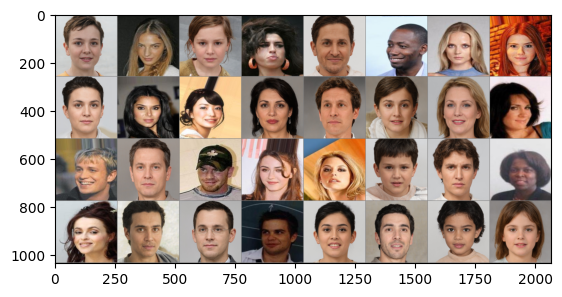

In [ ]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading (adjust based on your system)
)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [63]:
# Get the targets for the subset
subset_targets = [full_dataset.targets[i] for i in test_dataset.indices]

# Calculate the class distribution
class_distribution = Counter(subset_targets)
class_distribution

Counter({0: 1498, 1: 1391})

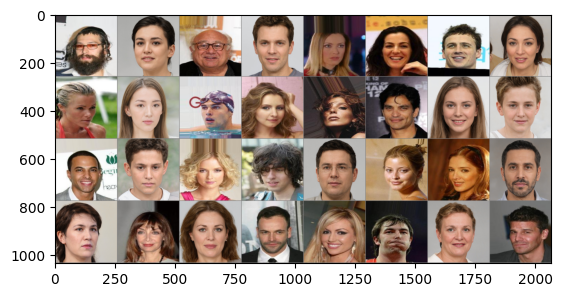

In [27]:

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading (adjust based on your system)
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


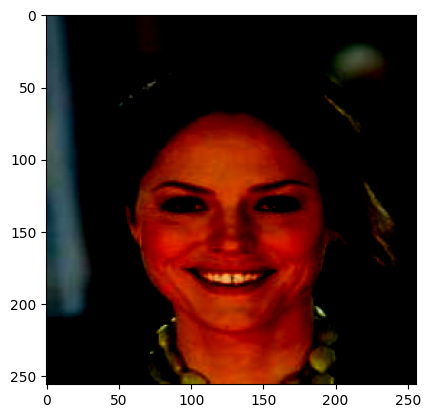

torch.Size([3, 256, 256])

In [28]:
#Sanity check (set shuffle=False in loader so order in file explorer is perserved)
index=0
npimg=train_loader.dataset[index][0].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_loader.dataset[index][1]

img, label=train_loader.dataset[index]
img.size()


<h2>ACTUAL CNN </h2>

In [29]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 64 * 64, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x
    


In [32]:
model = CNN(in_channels=3, num_classes=2).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs=10
for epoch in range(num_epochs):
 # Iterate over training batches
   print(f"Epoch [{epoch + 1}/{num_epochs}]")

   for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

Epoch [1/10]


100%|██████████| 211/211 [00:28<00:00,  7.43it/s]


Epoch [2/10]


100%|██████████| 211/211 [00:27<00:00,  7.78it/s]


Epoch [3/10]


100%|██████████| 211/211 [00:27<00:00,  7.58it/s]


Epoch [4/10]


100%|██████████| 211/211 [00:27<00:00,  7.55it/s]


Epoch [5/10]


100%|██████████| 211/211 [00:28<00:00,  7.44it/s]


Epoch [6/10]


100%|██████████| 211/211 [00:29<00:00,  7.14it/s]


Epoch [7/10]


100%|██████████| 211/211 [00:28<00:00,  7.29it/s]


Epoch [8/10]


100%|██████████| 211/211 [00:28<00:00,  7.41it/s]


Epoch [9/10]


100%|██████████| 211/211 [00:28<00:00,  7.38it/s]


Epoch [10/10]


100%|██████████| 211/211 [00:30<00:00,  7.01it/s]


In [64]:
# Set up of multiclass accuracy metric
acc = torchmetrics.Accuracy(task="binary")

# Iterate over the dataset batches
model.eval()
with torch.no_grad():
   for images, labels in test_loader:
       # Get predicted probabilities for test data batch
       outputs = model(images)
       _, preds = torch.max(outputs, 1)
       acc(preds, labels)
       #precision(preds, labels)
       #recall(preds, labels)

#Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 1.0
